# Задача проекта — разработка модели машинного обучения для поставщика услуг связи.

Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

# Описание услуг

Оператор предоставляет два основных типа услуг: 

1. Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
2. Интернет. Подключение может быть двух типов: через телефонную линию (DSL*,* от англ. *digital subscriber line*, «цифровая абонентская линия») или оптоволоконный кабель (*Fiber optic*).  

Также доступны такие услуги:

- Интернет-безопасность: антивирус (*DeviceProtection*) и блокировка небезопасных сайтов (*OnlineSecurity*);
- Выделенная линия технической поддержки (*TechSupport*);
- Облачное хранилище файлов для резервного копирования данных (*OnlineBackup*);
- Стриминговое телевидение (*StreamingTV*) и каталог фильмов (*StreamingMovies*).

За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.

# Описание данных

Данные состоят из файлов, полученных из разных источников:

- `contract_new.csv` — информация о договоре;
- `personal_new.csv` — персональные данные клиента;
- `internet_new.csv` — информация об интернет-услугах;
- `phone_new.csv` — информация об услугах телефонии.

Во всех файлах столбец `customerID` содержит код клиента.

Информация о договорах актуальна на 1 февраля 2020.

<div class="alert alert-block alert-success">
✔️ <b>Ревью 1</b>: Хорошо, что разместил в начале блокнота описание проекта.
</div>

In [174]:
%pip install lightgbm

Note: you may need to restart the kernel to use updated packages.


In [175]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import timedelta
from sklearn.preprocessing import StandardScaler
import catboost as cat
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, confusion_matrix, roc_curve, roc_auc_score, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
import lightgbm as lgb
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import OrdinalEncoder 
from sklearn.inspection import permutation_importance
from sklearn import svm
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier
from sklearn.pipeline import Pipeline
from datetime import datetime
from scipy import stats as st
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split, GridSearchCV
from lightgbm import LGBMClassifier
RANDOM_STATE = 190623

In [176]:
'''try:
    contract_df = pd.read_csv('/datasets/contract_new.csv')
    personal_df = pd.read_csv('/datasets/personal_new.csv')
    internet_df = pd.read_csv('/datasets/internet_new.csv')
    phone_df = pd.read_csv('/datasets/phone_new.csv')
    contract_df_copy = contract_df.copy()
except:
    contract_df = pd.read_csv(r'C:\final_provider\contract_new.csv')
    personal_df = pd.read_csv(r'C:\final_provider\personal_new.csv')
    internet_df = pd.read_csv(r'C:\final_provider\internet_new.csv')
    phone_df = pd.read_csv(r'C:\final_provider\phone_new.csv')
    contract_df_copy = contract_df.copy()'''
try:
    contract_df = pd.read_csv('contract_new.csv')
    personal_df = pd.read_csv('personal_new.csv')
    internet_df = pd.read_csv('internet_new.csv')
    phone_df = pd.read_csv('phone_new.csv')
    contract_df_copy = contract_df.copy()
except:
    contract_df = pd.read_csv(r'C:\final_provider\contract_new.csv')
    personal_df = pd.read_csv(r'C:\final_provider\personal_new.csv')
    internet_df = pd.read_csv(r'C:\final_provider\internet_new.csv')
    phone_df = pd.read_csv(r'C:\final_provider\phone_new.csv')
    contract_df_copy = contract_df.copy()

In [177]:
def analysis_df(df):
    rows_count, columns_count = df.shape
    print('Количество стобцов:', columns_count)
    print('Количество строк:', rows_count)
    display(df.head(5))
    display(df.describe())
    df.info()

In [178]:
analysis_df(contract_df)

Количество стобцов: 8
Количество строк: 7043


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5


,MonthlyCharges
count,7043.000000
mean,64.761692
std,30.090047
min,18.250000
25%,35.500000
50%,70.350000
75%,89.850000
max,118.750000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


In [179]:
contract_df['PaymentMethod'].value_counts()

Electronic check             2365
Mailed check                 1612
Bank transfer (automatic)    1544
Credit card (automatic)      1522
Name: PaymentMethod, dtype: int64

In [180]:
contract_df['Type'].value_counts()

Month-to-month    3875
Two year          1695
One year          1473
Name: Type, dtype: int64

**Выводы**:
* В данных нет пропусков

* Надо переименовать `customerID` -> `CustomerID`
* `BeginDate` и `EndDate` надо перевести в формат даты 
* `No` в `EndDate` означает, что пользователь продолжает пользоваться услугами - это целевой признак 
* После выделения целевого признака надо будет заменить `No` на `01.02.2020` в `EndDate`
* `TotalCharges` надо перевести в числовой тип
* К `PaymentMethod`, `Type` и `PaperlessBilling` надо применить One Hot Encoding (в зависимости от применяемой модели)

In [181]:
analysis_df(personal_df)

Количество стобцов: 5
Количество строк: 7043


,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


,SeniorCitizen
count,7043.000000
mean,0.162147
std,0.368612
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


**Выводы**:
* В данных нет пропусков
* Надо переименовать `customerID` -> `CustomerID`, `gender` -> `Gender`
* К `gender`, `Partner` и `Dependents` надо применить One Hot Encoding (в зависимости от применяемой модели)

In [182]:
analysis_df(internet_df)

Количество стобцов: 8
Количество строк: 5517


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
count,5517,5517,5517,5517,5517,5517,5517,5517
unique,5517,2,2,2,2,2,2,2
top,7590-VHVEG,Fiber optic,No,No,No,No,No,No
freq,1,3096,3498,3088,3095,3473,2810,2785


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


In [183]:
internet_df['InternetService'].value_counts()

Fiber optic    3096
DSL            2421
Name: InternetService, dtype: int64

**Выводы**:
* В данных нет пропусков
* Данные есть не по всем клиентам
* Надо переименовать `customerID` -> `CustomerID`
* К `InternetService`, `OnlineSecurity`, `OnlineBackup`, `DeviceProtection`, `TechSupport`, `StreamingTV`, `StreamingMovies` надо применить One Hot Encoding (в зависимости от применяемой модели)

In [184]:
analysis_df(phone_df)

Количество стобцов: 2
Количество строк: 6361


,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


,customerID,MultipleLines
count,6361,6361
unique,6361,2
top,5575-GNVDE,No
freq,1,3390


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


**Выводы**:
* В данных нет пропусков
* Данные есть не по всем клиентам
* Надо переименовать `customerID` -> `CustomerID`
* К `MultipleLines` надо применить One Hot Encoding (в зависимости от применяемой модели)

# План

* Проанализировать содержимое файлов данных, проверить типы данных, обнаружить наличие пропущенных значений и определить необходимость преобразования данных.(В таблице contract есть столбцы с датами, один из них, целевой признак - EndDate - прекращение контракта.)

<div class="alert alert-block alert-warning">
⚠️ <b>Ревью 2</b>: В проекте нужно решить задачу бинарной классификации: ушел клиент или нет. EndDate - не целевой признак, так как мы предсказываем не дату ухода клиента, а факт ухода без привязки к дате. Целевого признака в исходном датасете нет, его нужно создать на основе EndDate. 0 - если в EndDate стоит 'No', 1 - если дата. Дальше по тексту написано правильнее.
</div>

* Подготовить данные на основе выводов, полученных на предыдущем шаге. Это может включать заполнение пропущенных значений, преобразование типов данных, масштабирование или нормализацию данных, а также удаление необходимых столбцов.Обьединение данных в 1 датасет.
* Провести исследовательский анализ данных, включающий визуализацию данных и устранение выбросов. Это поможет понять распределение данных, выявить возможные аномалии или выбросы, а также определить связи между переменными.
* Обучит модель предсказвыть ухода клиента – отказ от продолжения пользования услугами, предоставляемыми заказчиком. Произвести перебор моделей и подобрать их параметры. Это может включать выбор и обучение различных моделей машинного обучения,тестирование лучшей модели, построение графика ROC, рассчет дополнительной метрики accuracy, вывод матрицы ошибок, анализ важности признаков, настройку их гиперпараметров и сравнение их производительности на основе метрик оценки.

<div class="alert alert-block alert-warning">
⚠️ <b>Ревью 2</b>: Настройка гиперпараметров делается на этапе обучения модели, а не в конце разработки.
</div>

* Сделать выводы на основе проделанной работы. В этом разделе можно описать выбранную модель, ее производительность, обсудить важность переменных, предоставить интерпретацию результатов и предложить возможные рекомендации или дальнейшие исследования.

<div class="alert alert-block alert-warning">
⚠️ <b>Ревью 1:</b> Кажется, что план немного расплывчатый. <s>Как минимум нужно разобраться с целевой переменной. Что ты будешь предсказывать моделью?</s> Какие модели собираешься обучать? В какой пропорции разбивать на выборки? Как кодировать и масштабтровать признаки (при необходимости) без утечки данных? Будешь ли генерировать новые признаки? Какие метрики будешь оптимизировать? <s>Не забудь включить в план тестирование лучшей модели, построение графика ROC, рассчет дополнительной метрики accuracy, вывод матрицы ошибок, анализ важности признаков.</s> Рекомендую обратиться к материалам вводного вебинара для облегчения написания плана.
</div>

<div class="alert alert-block alert-info">
<b>Комментарий разработчика:</b> 
Добавил. Про генерирование новых признаков и какие модели буду обчучать, пока не знаю. Добавлю их в план по мере продвижения решения над задачей.
</div>

<div class="alert alert-block alert-danger">
❌ <s><b>Ревью 2</b>: В правилах финального спринта, которые обсуждались на вводном вебинаре, есть требование обязательно задать вопросы тимлиду в первом блокноте с планом или явно написать, что вопросов нет. Прошу, написать, остались ли неясности перед моделированием.</s>
</div>

# Вопросы
Вопросов нет.

<div class="alert alert-block alert-success">
✔️ <b>Ревью 3</b>: План и предварительное изучение данных приняты. Желаю плодотворного исследовательского анализа и моделирования!
</div>

# Первичная подготовка данных

Переименуем столбцы, для того, чтобы они все были в одном формате

In [185]:
contract_df = contract_df.rename(columns={'customerID': 'CustomerID'})
print(contract_df.columns.values)

['CustomerID' 'BeginDate' 'EndDate' 'Type' 'PaperlessBilling'
 'PaymentMethod' 'MonthlyCharges' 'TotalCharges']


In [186]:
personal_df = personal_df.rename(columns={'customerID': 'CustomerID', 'gender': 'Gender'})
print(personal_df.columns.values)

['CustomerID' 'Gender' 'SeniorCitizen' 'Partner' 'Dependents']


In [187]:
internet_df = internet_df.rename(columns={'customerID': 'CustomerID'})
print(internet_df.columns.values)

['CustomerID' 'InternetService' 'OnlineSecurity' 'OnlineBackup'
 'DeviceProtection' 'TechSupport' 'StreamingTV' 'StreamingMovies']


In [188]:
phone_df = phone_df.rename(columns={'customerID': 'CustomerID'})
print(phone_df.columns.values)

['CustomerID' 'MultipleLines']


Добавим целевой признак Churn, который будет означать отказался клиент от услуг или нет.
Если значение в столбце EndDate равно "No", то значит клиент не ушел и целевой признак равен 0.
Если дата ухода есть, то целевой признак равен 1.

In [189]:
contract_df['Churn'] = (contract_df['EndDate'] != 'No').astype(int)
contract_df.head(15)

,CustomerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04,0
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84,0
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17,0
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6,0
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5,0
5,9305-CDSKC,2019-03-01,No,Month-to-month,Yes,Electronic check,99.65,1150.96,0
6,1452-KIOVK,2018-04-01,No,Month-to-month,Yes,Credit card (automatic),89.10,2058.21,0
7,6713-OKOMC,2019-04-01,No,Month-to-month,No,Mailed check,29.75,300.48,0
8,7892-POOKP,2017-07-01,No,Month-to-month,Yes,Electronic check,104.80,3573.68,0
9,6388-TABGU,2014-12-01,2017-05-01,One year,No,Bank transfer (automatic),56.15,1628.35,1


Заменим все значения "No" в EndDate на дату выгрузки датасета (01.02.2020)

In [190]:
contract_df['EndDate'] = contract_df['EndDate'].replace(['No'], ['2020-02-01'])
print(contract_df[contract_df['EndDate'] == 'No'].shape[0])

0


Переведем EndDate и BeginDate в формат даты

In [191]:
contract_df['BeginDate'] = pd.to_datetime(contract_df['BeginDate'], format='%Y-%m-%d')
contract_df['EndDate'] = pd.to_datetime(contract_df['EndDate'], format='%Y-%m-%d')
contract_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   CustomerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   object        
 8   Churn             7043 non-null   int32         
dtypes: datetime64[ns](2), float64(1), int32(1), object(5)
memory usage: 467.8+ KB


Заведем новый столбец TotalDays, который будет означать, сколько пользователь пользовался услугами

In [192]:
contract_df['TotalDays'] = (contract_df['EndDate'] - contract_df['BeginDate']).dt.days

Переведем TotalCharges в числовой тип

In [193]:
contract_df['TotalCharges'] = pd.to_numeric(contract_df['TotalCharges'], errors ='coerce')
contract_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   CustomerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7032 non-null   float64       
 8   Churn             7043 non-null   int32         
 9   TotalDays         7043 non-null   int64         
dtypes: datetime64[ns](2), float64(2), int32(1), int64(1), object(4)
memory usage: 522.8+ KB


Видно, что в столбце TotalCharges появились пропуски, посмотрим на строки с ними

In [194]:
contract_df[contract_df['TotalCharges'].isnull()]

,CustomerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,TotalDays
488,4472-LVYGI,2020-02-01,2020-02-01,Two year,Yes,Bank transfer (automatic),52.55,NaN,0,0
753,3115-CZMZD,2020-02-01,2020-02-01,Two year,No,Mailed check,20.25,NaN,0,0
936,5709-LVOEQ,2020-02-01,2020-02-01,Two year,No,Mailed check,80.85,NaN,0,0
1082,4367-NUYAO,2020-02-01,2020-02-01,Two year,No,Mailed check,25.75,NaN,0,0
1340,1371-DWPAZ,2020-02-01,2020-02-01,Two year,No,Credit card (automatic),56.05,NaN,0,0
3331,7644-OMVMY,2020-02-01,2020-02-01,Two year,No,Mailed check,19.85,NaN,0,0
3826,3213-VVOLG,2020-02-01,2020-02-01,Two year,No,Mailed check,25.35,NaN,0,0
4380,2520-SGTTA,2020-02-01,2020-02-01,Two year,No,Mailed check,20.00,NaN,0,0
5218,2923-ARZLG,2020-02-01,2020-02-01,One year,Yes,Mailed check,19.70,NaN,0,0
6670,4075-WKNIU,2020-02-01,2020-02-01,Two year,No,Mailed check,73.35,NaN,0,0


Видно, что все эти клиенты подключены всего 1 день, заполним пропуски в TotalCharges на 0

In [195]:
# моя правка (оказывается пропуски были изначально)
list_id = list(contract_df[contract_df['TotalCharges'].isnull()]['CustomerID'])
filtered_dataset = contract_df_copy[contract_df_copy['customerID'].isin(list_id)]
filtered_dataset

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
488,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,
753,3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,
936,5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,
1082,4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,
1340,1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,
3331,7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,
3826,3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,
4380,2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,
5218,2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,
6670,4075-WKNIU,2020-02-01,No,Two year,No,Mailed check,73.35,


Получаем, что дата начала отчетного периода совпала с датой начала, заполним пропуски средним значением по столбцу

In [196]:
mean_value = contract_df['TotalCharges'].mean()
contract_df['TotalCharges'] = contract_df['TotalCharges'].fillna(mean_value)

<div class="alert alert-block alert-warning">
⚠️ <b>Ревью 6:</b> Вероятнее в датасете даты приведены к началу отчетного периода, поэтому новые клиенты могли пользоваться услугами уже не первый день. Поэтому есть и другой вариант заполнения - с помощью другого столбца с денежными суммами.
</div>

<div class="alert alert-block alert-info">
<b>Комментарий разработчика:</b> 
Исправил.
</div>

In [197]:
contract_df['TotalCharges'].isnull().sum()

0

In [198]:
contract_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   CustomerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   float64       
 8   Churn             7043 non-null   int32         
 9   TotalDays         7043 non-null   int64         
dtypes: datetime64[ns](2), float64(2), int32(1), int64(1), object(4)
memory usage: 522.8+ KB


Приведем все категориальные столбцы в других таблицах к нижнему регистру.

In [199]:
contract_df['CustomerID'] = contract_df['CustomerID'].str.lower()
contract_df['Type'] = contract_df['Type'].str.lower()
contract_df['PaperlessBilling'] = contract_df['PaperlessBilling'].str.lower()
contract_df['PaymentMethod'] = contract_df['PaymentMethod'].str.lower()

In [200]:
for column in internet_df.columns:
    internet_df[column] = internet_df[column].str.lower()

In [201]:
for column in ['CustomerID', 'Gender', 'Partner', 'Dependents']:
    personal_df[column] = personal_df[column].str.lower()

In [202]:
for column in phone_df.columns:
    phone_df[column] = phone_df[column].str.lower()

In [203]:
contract_df.head(15)

,CustomerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,TotalDays
0,7590-vhveg,2020-01-01,2020-02-01,month-to-month,yes,electronic check,29.85,31.04,0,31
1,5575-gnvde,2017-04-01,2020-02-01,one year,no,mailed check,56.95,2071.84,0,1036
2,3668-qpybk,2019-10-01,2020-02-01,month-to-month,yes,mailed check,53.85,226.17,0,123
3,7795-cfocw,2016-05-01,2020-02-01,one year,no,bank transfer (automatic),42.30,1960.60,0,1371
4,9237-hqitu,2019-09-01,2020-02-01,month-to-month,yes,electronic check,70.70,353.50,0,153
5,9305-cdskc,2019-03-01,2020-02-01,month-to-month,yes,electronic check,99.65,1150.96,0,337
6,1452-kiovk,2018-04-01,2020-02-01,month-to-month,yes,credit card (automatic),89.10,2058.21,0,671
7,6713-okomc,2019-04-01,2020-02-01,month-to-month,no,mailed check,29.75,300.48,0,306
8,7892-pookp,2017-07-01,2020-02-01,month-to-month,yes,electronic check,104.80,3573.68,0,945
9,6388-tabgu,2014-12-01,2017-05-01,one year,no,bank transfer (automatic),56.15,1628.35,1,882


In [204]:
internet_df.head()

,CustomerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-vhveg,dsl,no,yes,no,no,no,no
1,5575-gnvde,dsl,yes,no,yes,no,no,no
2,3668-qpybk,dsl,yes,yes,no,no,no,no
3,7795-cfocw,dsl,yes,no,yes,yes,no,no
4,9237-hqitu,fiber optic,no,no,no,no,no,no


In [205]:
personal_df.head()

,CustomerID,Gender,SeniorCitizen,Partner,Dependents
0,7590-vhveg,female,0,yes,no
1,5575-gnvde,male,0,no,no
2,3668-qpybk,male,0,no,no
3,7795-cfocw,male,0,no,no
4,9237-hqitu,female,0,no,no


In [206]:
phone_df.head()

,CustomerID,MultipleLines
0,5575-gnvde,no
1,3668-qpybk,no
2,9237-hqitu,no
3,9305-cdskc,yes
4,1452-kiovk,yes


Объединим все данные в один датафрейм

In [207]:
full_data = contract_df.merge(internet_df, on='CustomerID', how='left')
full_data = full_data.merge(personal_df, on='CustomerID', how='left')
full_data = full_data.merge(phone_df, on='CustomerID', how='left')

Проверим, что все значения CustomerID уникальные

In [208]:
full_data['CustomerID'].is_unique

True

In [209]:
analysis_df(full_data)

Количество стобцов: 22
Количество строк: 7043


,CustomerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,TotalDays,...,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Gender,SeniorCitizen,Partner,Dependents,MultipleLines
0,7590-vhveg,2020-01-01,2020-02-01,month-to-month,yes,electronic check,29.85,31.04,0,31,...,yes,no,no,no,no,female,0,yes,no,NaN
1,5575-gnvde,2017-04-01,2020-02-01,one year,no,mailed check,56.95,2071.84,0,1036,...,no,yes,no,no,no,male,0,no,no,no
2,3668-qpybk,2019-10-01,2020-02-01,month-to-month,yes,mailed check,53.85,226.17,0,123,...,yes,no,no,no,no,male,0,no,no,no
3,7795-cfocw,2016-05-01,2020-02-01,one year,no,bank transfer (automatic),42.30,1960.60,0,1371,...,no,yes,yes,no,no,male,0,no,no,NaN
4,9237-hqitu,2019-09-01,2020-02-01,month-to-month,yes,electronic check,70.70,353.50,0,153,...,no,no,no,no,no,female,0,no,no,no


,MonthlyCharges,TotalCharges,Churn,TotalDays,SeniorCitizen
count,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000
mean,64.761692,2118.621822,0.156325,898.555729,0.162147
std,30.090047,2111.085448,0.363189,683.130510,0.368612
min,18.250000,19.050000,0.000000,0.000000,0.000000
25%,35.500000,440.495000,0.000000,276.000000,0.000000
50%,70.350000,1349.710000,0.000000,761.000000,0.000000
75%,89.850000,3236.690000,0.000000,1461.000000,0.000000
max,118.750000,9221.380000,1.000000,2314.000000,1.000000


<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   CustomerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   float64       
 8   Churn             7043 non-null   int32         
 9   TotalDays         7043 non-null   int64         
 10  InternetService   5517 non-null   object        
 11  OnlineSecurity    5517 non-null   object        
 12  OnlineBackup      5517 non-null   object        
 13  DeviceProtection  5517 non-null   object        
 14  TechSupport       5517 n

Пропуски в InternetService, OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport, StreamingTV, StreamingMovies и MultipleLines скорее всего означают, что услуги не подключены. Заменим пропуски на "No"

In [210]:
for column in ('InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'MultipleLines'):
    full_data[column] = full_data[column].fillna('No')

In [211]:
full_data.info()
full_data.head(15)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   CustomerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   float64       
 8   Churn             7043 non-null   int32         
 9   TotalDays         7043 non-null   int64         
 10  InternetService   7043 non-null   object        
 11  OnlineSecurity    7043 non-null   object        
 12  OnlineBackup      7043 non-null   object        
 13  DeviceProtection  7043 non-null   object        
 14  TechSupport       7043 n

,CustomerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,TotalDays,...,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Gender,SeniorCitizen,Partner,Dependents,MultipleLines
0,7590-vhveg,2020-01-01,2020-02-01,month-to-month,yes,electronic check,29.85,31.04,0,31,...,yes,no,no,no,no,female,0,yes,no,No
1,5575-gnvde,2017-04-01,2020-02-01,one year,no,mailed check,56.95,2071.84,0,1036,...,no,yes,no,no,no,male,0,no,no,no
2,3668-qpybk,2019-10-01,2020-02-01,month-to-month,yes,mailed check,53.85,226.17,0,123,...,yes,no,no,no,no,male,0,no,no,no
3,7795-cfocw,2016-05-01,2020-02-01,one year,no,bank transfer (automatic),42.30,1960.60,0,1371,...,no,yes,yes,no,no,male,0,no,no,No
4,9237-hqitu,2019-09-01,2020-02-01,month-to-month,yes,electronic check,70.70,353.50,0,153,...,no,no,no,no,no,female,0,no,no,no
5,9305-cdskc,2019-03-01,2020-02-01,month-to-month,yes,electronic check,99.65,1150.96,0,337,...,no,yes,no,yes,yes,female,0,no,no,yes
6,1452-kiovk,2018-04-01,2020-02-01,month-to-month,yes,credit card (automatic),89.10,2058.21,0,671,...,yes,no,no,yes,no,male,0,no,yes,yes
7,6713-okomc,2019-04-01,2020-02-01,month-to-month,no,mailed check,29.75,300.48,0,306,...,no,no,no,no,no,female,0,no,no,No
8,7892-pookp,2017-07-01,2020-02-01,month-to-month,yes,electronic check,104.80,3573.68,0,945,...,no,yes,yes,yes,yes,female,0,yes,no,yes
9,6388-tabgu,2014-12-01,2017-05-01,one year,no,bank transfer (automatic),56.15,1628.35,1,882,...,yes,no,no,no,no,male,0,no,yes,no


# Исследовательский анализ данных

In [218]:
numeric_columns = ['MonthlyCharges', 'TotalCharges', 'TotalDays']
categorial_columns = [
    'Type',
    'PaperlessBilling',
    'PaymentMethod',
    'Gender',
    'SeniorCitizen',
    'Partner',
    'Dependents',
    'InternetService', 
    'OnlineSecurity', 
    'OnlineBackup', 
    'DeviceProtection', 
    'TechSupport', 
    'StreamingTV', 
    'StreamingMovies', 
    'MultipleLines',
]

In [219]:
full_data['OnlineSecurity'] = full_data['OnlineSecurity'].str.lower()
full_data['OnlineBackup'] = full_data['OnlineBackup'].str.lower()
full_data['DeviceProtection'] = full_data['DeviceProtection'].str.lower()
full_data['TechSupport'] = full_data['TechSupport'].str.lower()
full_data['StreamingTV'] = full_data['StreamingTV'].str.lower()
full_data['StreamingMovies'] = full_data['StreamingMovies'].str.lower()
full_data['MultipleLines'] = full_data['MultipleLines'].str.lower()

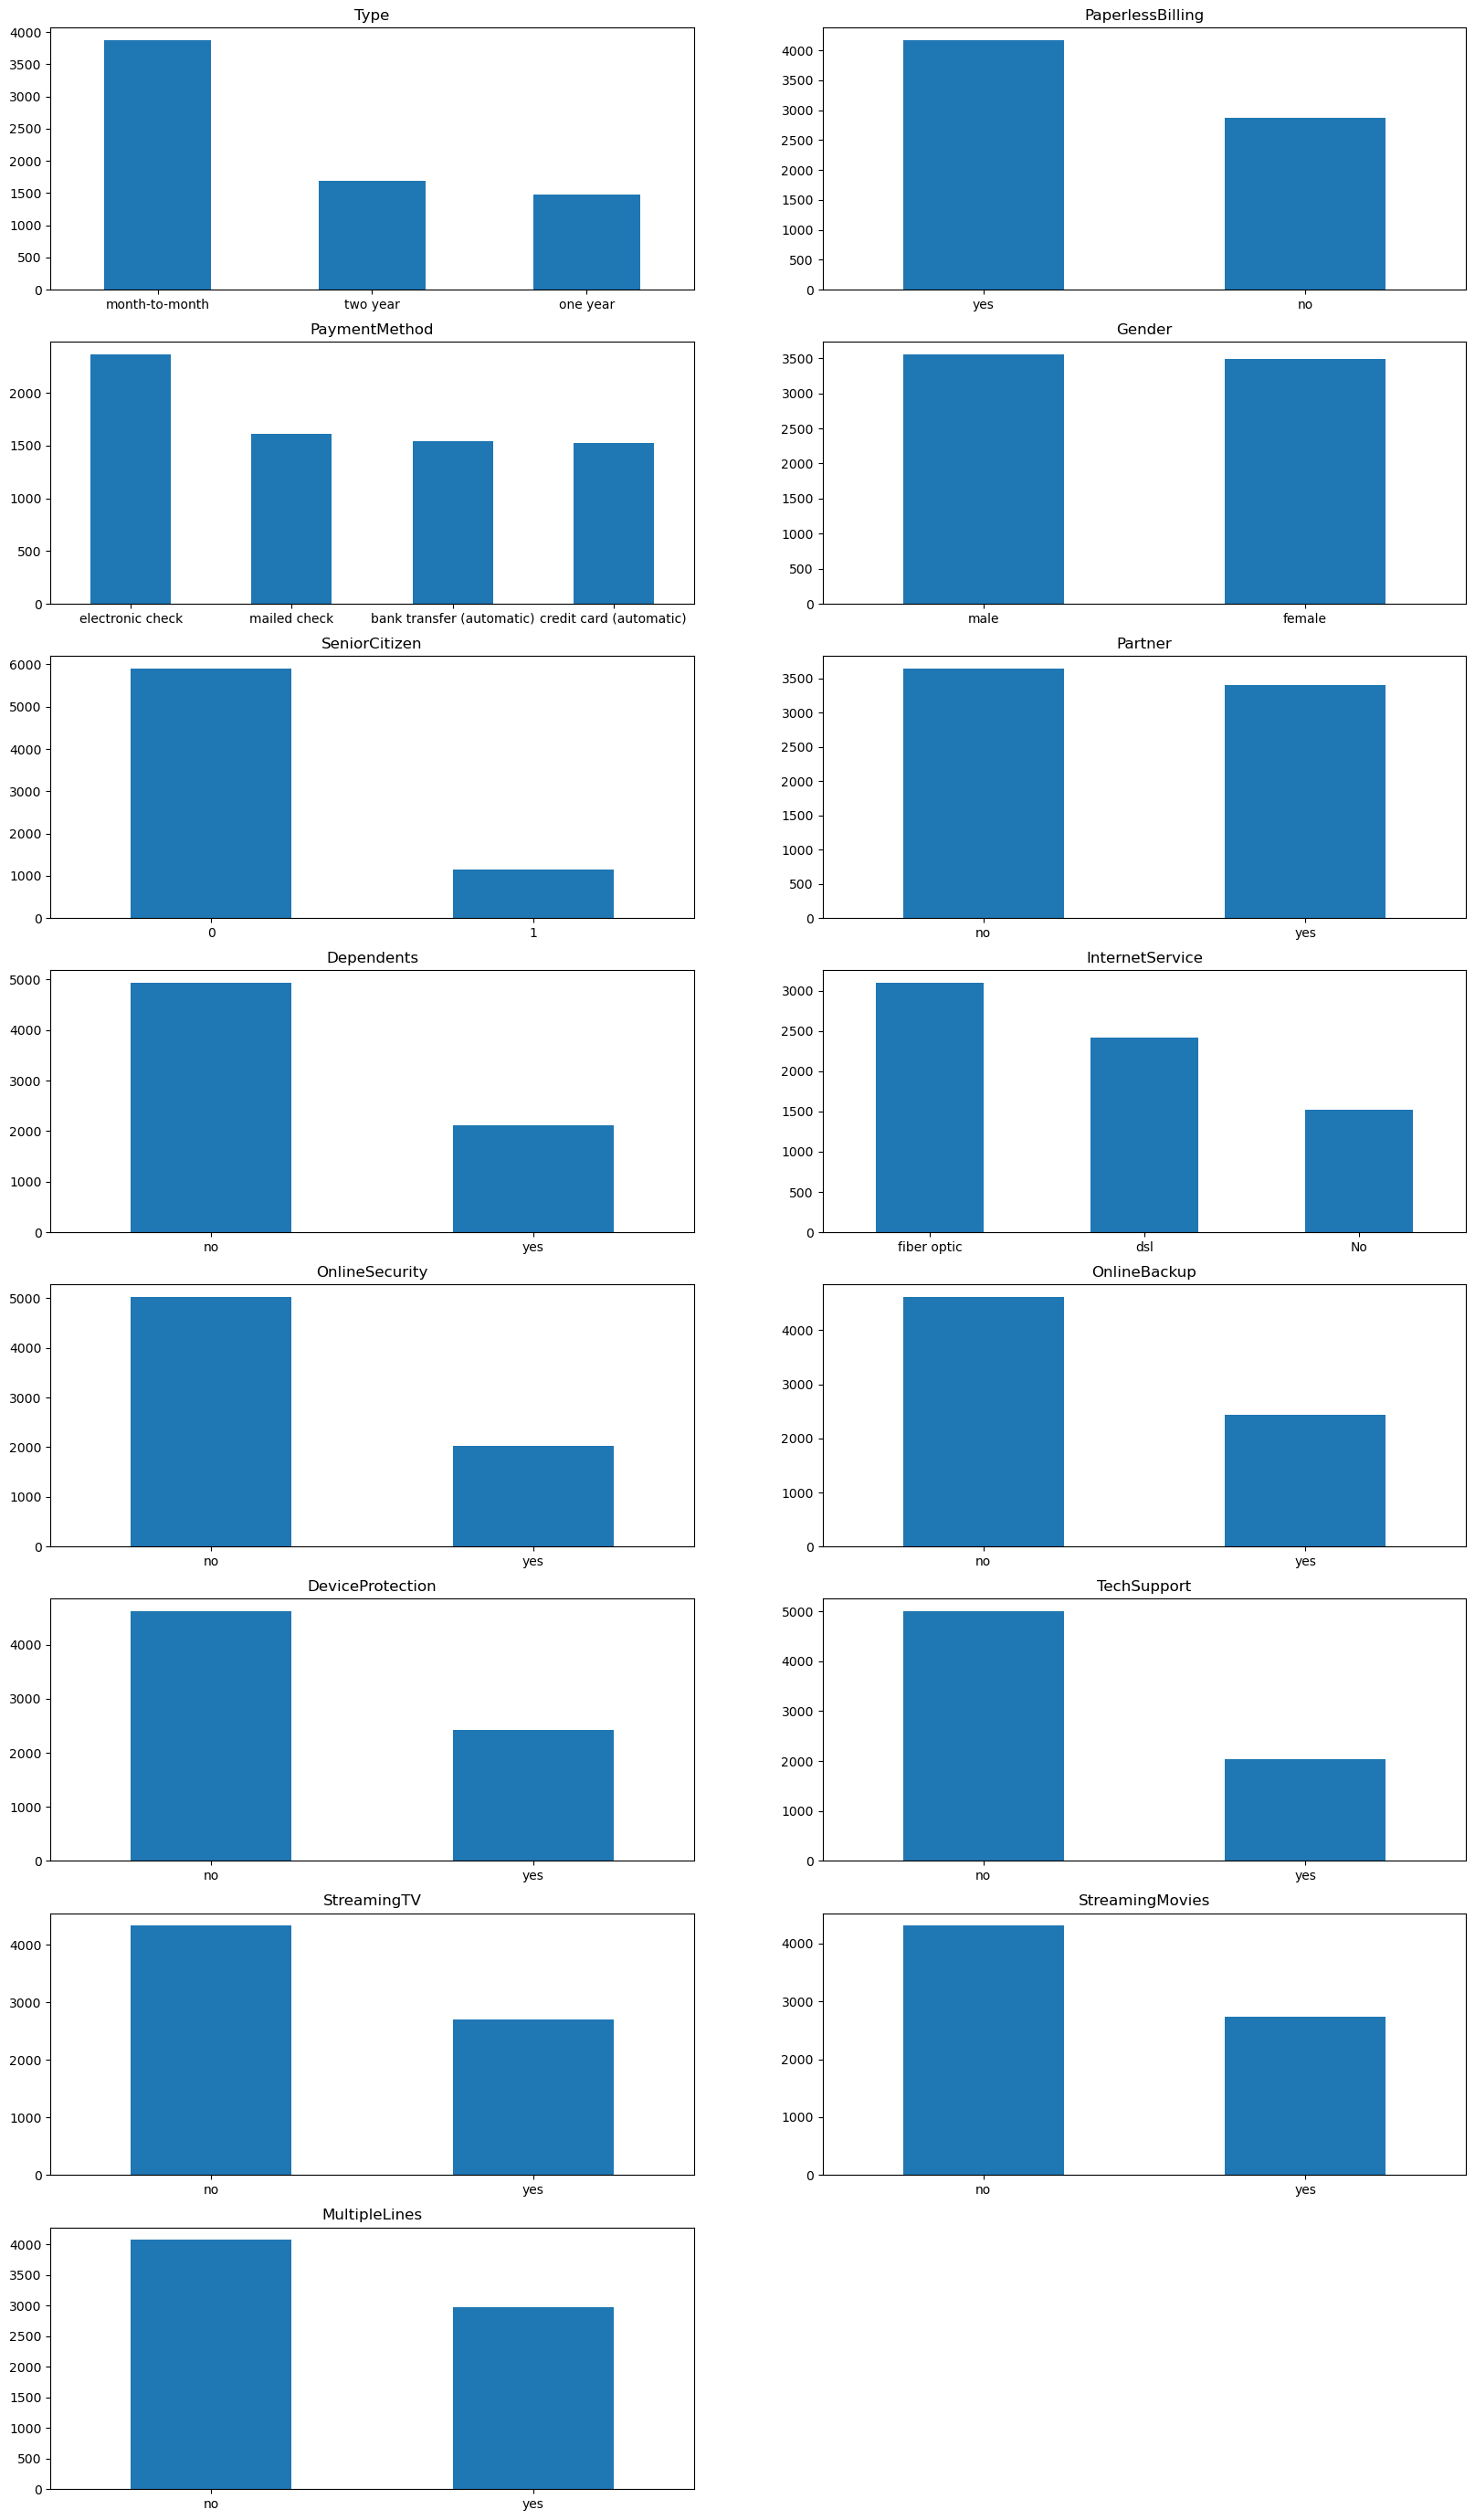

In [220]:
cols = 2
rows = int(np.ceil(len(categorial_columns) / cols))

plt.figure(figsize=(20, 35))

for idx, column in enumerate(categorial_columns):
    ax = plt.subplot(rows, cols, idx + 1)
    
    full_data[column].value_counts().plot(
        kind='bar', 
        title=column, 
        ax=ax,
        rot=0,
    )
        
plt.show()

# Выводы:

* Самый популярный способ оплаты - помесячный
* Люди чаще предпочитают получать счета в электронном виде и оплачивать их при помощи электронного чека
* Самый частый способ подключения - оптоволокно
* Дополнительные услуги OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport, StreamingTV, StreamingMovies, MultipleLines не пользуются популярностью у пользователей

Посмотрим распределение значений и диаграммы размаха для количественных данных

In [221]:
def plot_numerical(df):
    cols = 3
    rows = 2

    plt.figure(figsize=(15, 10))

    idx = 0
    for column in numeric_columns:
        idx += 1 
    
        plt.subplot(rows, cols, idx)
        plt.hist(df[column])
        plt.title(column)
    
    for column in numeric_columns:
        idx += 1 
    
        plt.subplot(rows, cols, idx)
        plt.boxplot(df[column])
        plt.title(column)
        
    plt.show()

    display(df[numeric_columns].describe())

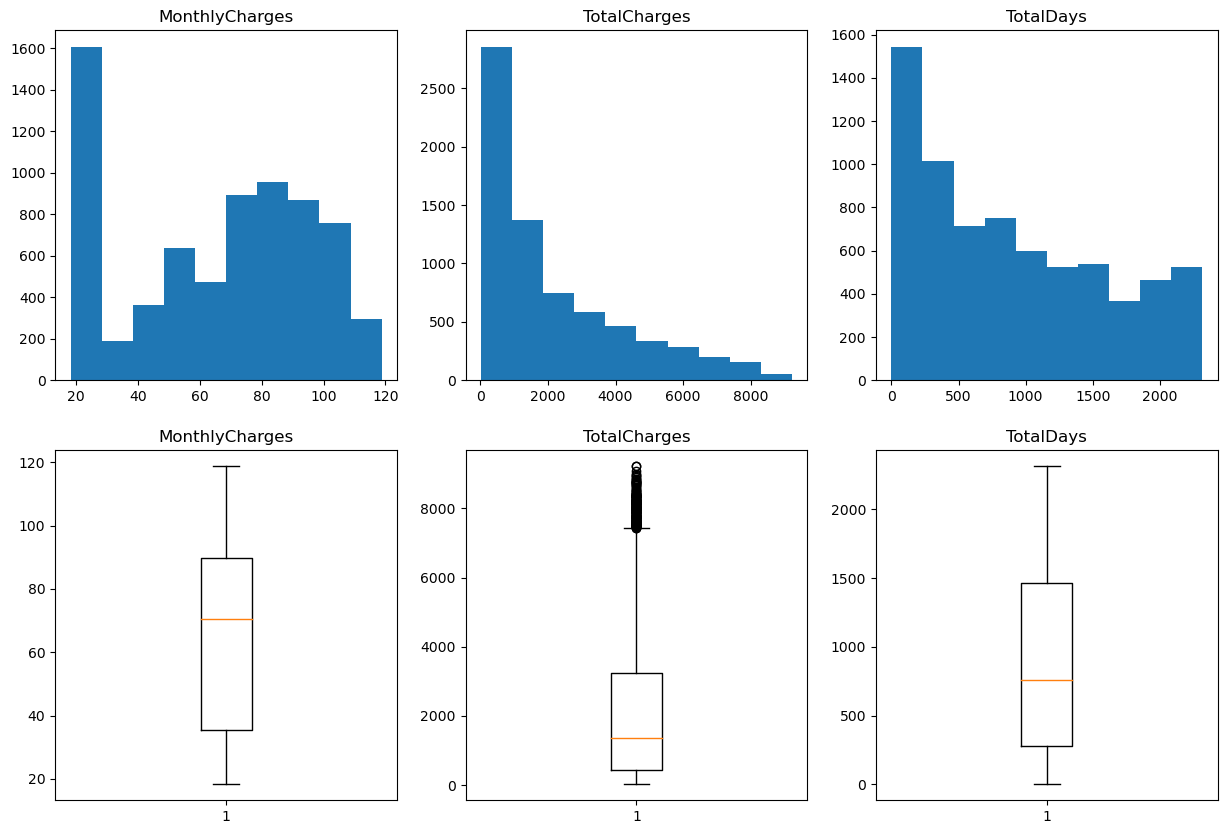

,MonthlyCharges,TotalCharges,TotalDays
count,7043.000000,7043.000000,7043.000000
mean,64.761692,2118.621822,898.555729
std,30.090047,2111.085448,683.130510
min,18.250000,19.050000,0.000000
25%,35.500000,440.495000,276.000000
50%,70.350000,1349.710000,761.000000
75%,89.850000,3236.690000,1461.000000
max,118.750000,9221.380000,2314.000000


In [222]:
plot_numerical(full_data)

# Выводы:

* Значения в столбце TotalCharges убывают, что является ожидаемой закономерностью, - чем больше общая цена, тем меньше людей

<div class="alert alert-block alert-info">
<b>Комментарий разработчика:</b> 
Изменил вывод.
</div>

<div class="alert alert-block alert-danger">
❌ <b>Ревью 6</b>: Для подтверждения этого вывода необходимо перерисовать чертежи, разделяя их на две компоненты по целевой переменной - для ушедших коиентов и оставшихся.
</div>

* У MonthlyCharges виден пик в районе 20, что является минимальным значением
* В столбце TotalDays видно 1 пика - в районе новых клиентов
* Есть выбросы в TotalCharges, но они не являются ошибочными/аномальными. Эти выбросы означают, что существуют выплаты значительно выше остальных.

<div class="alert alert-block alert-info">
<b>Комментарий разработчика:</b> 
Изменил вывод.
</div>

<div class="alert alert-block alert-danger">
❌ <b>Ревью 6</b>: Если выбросов нет, то как можно охарактеризовать черные точки над верхним усом ящика TotalCharges?
</div>

Посмотрим на распределение категорильных признаков относительно целевого признака Result

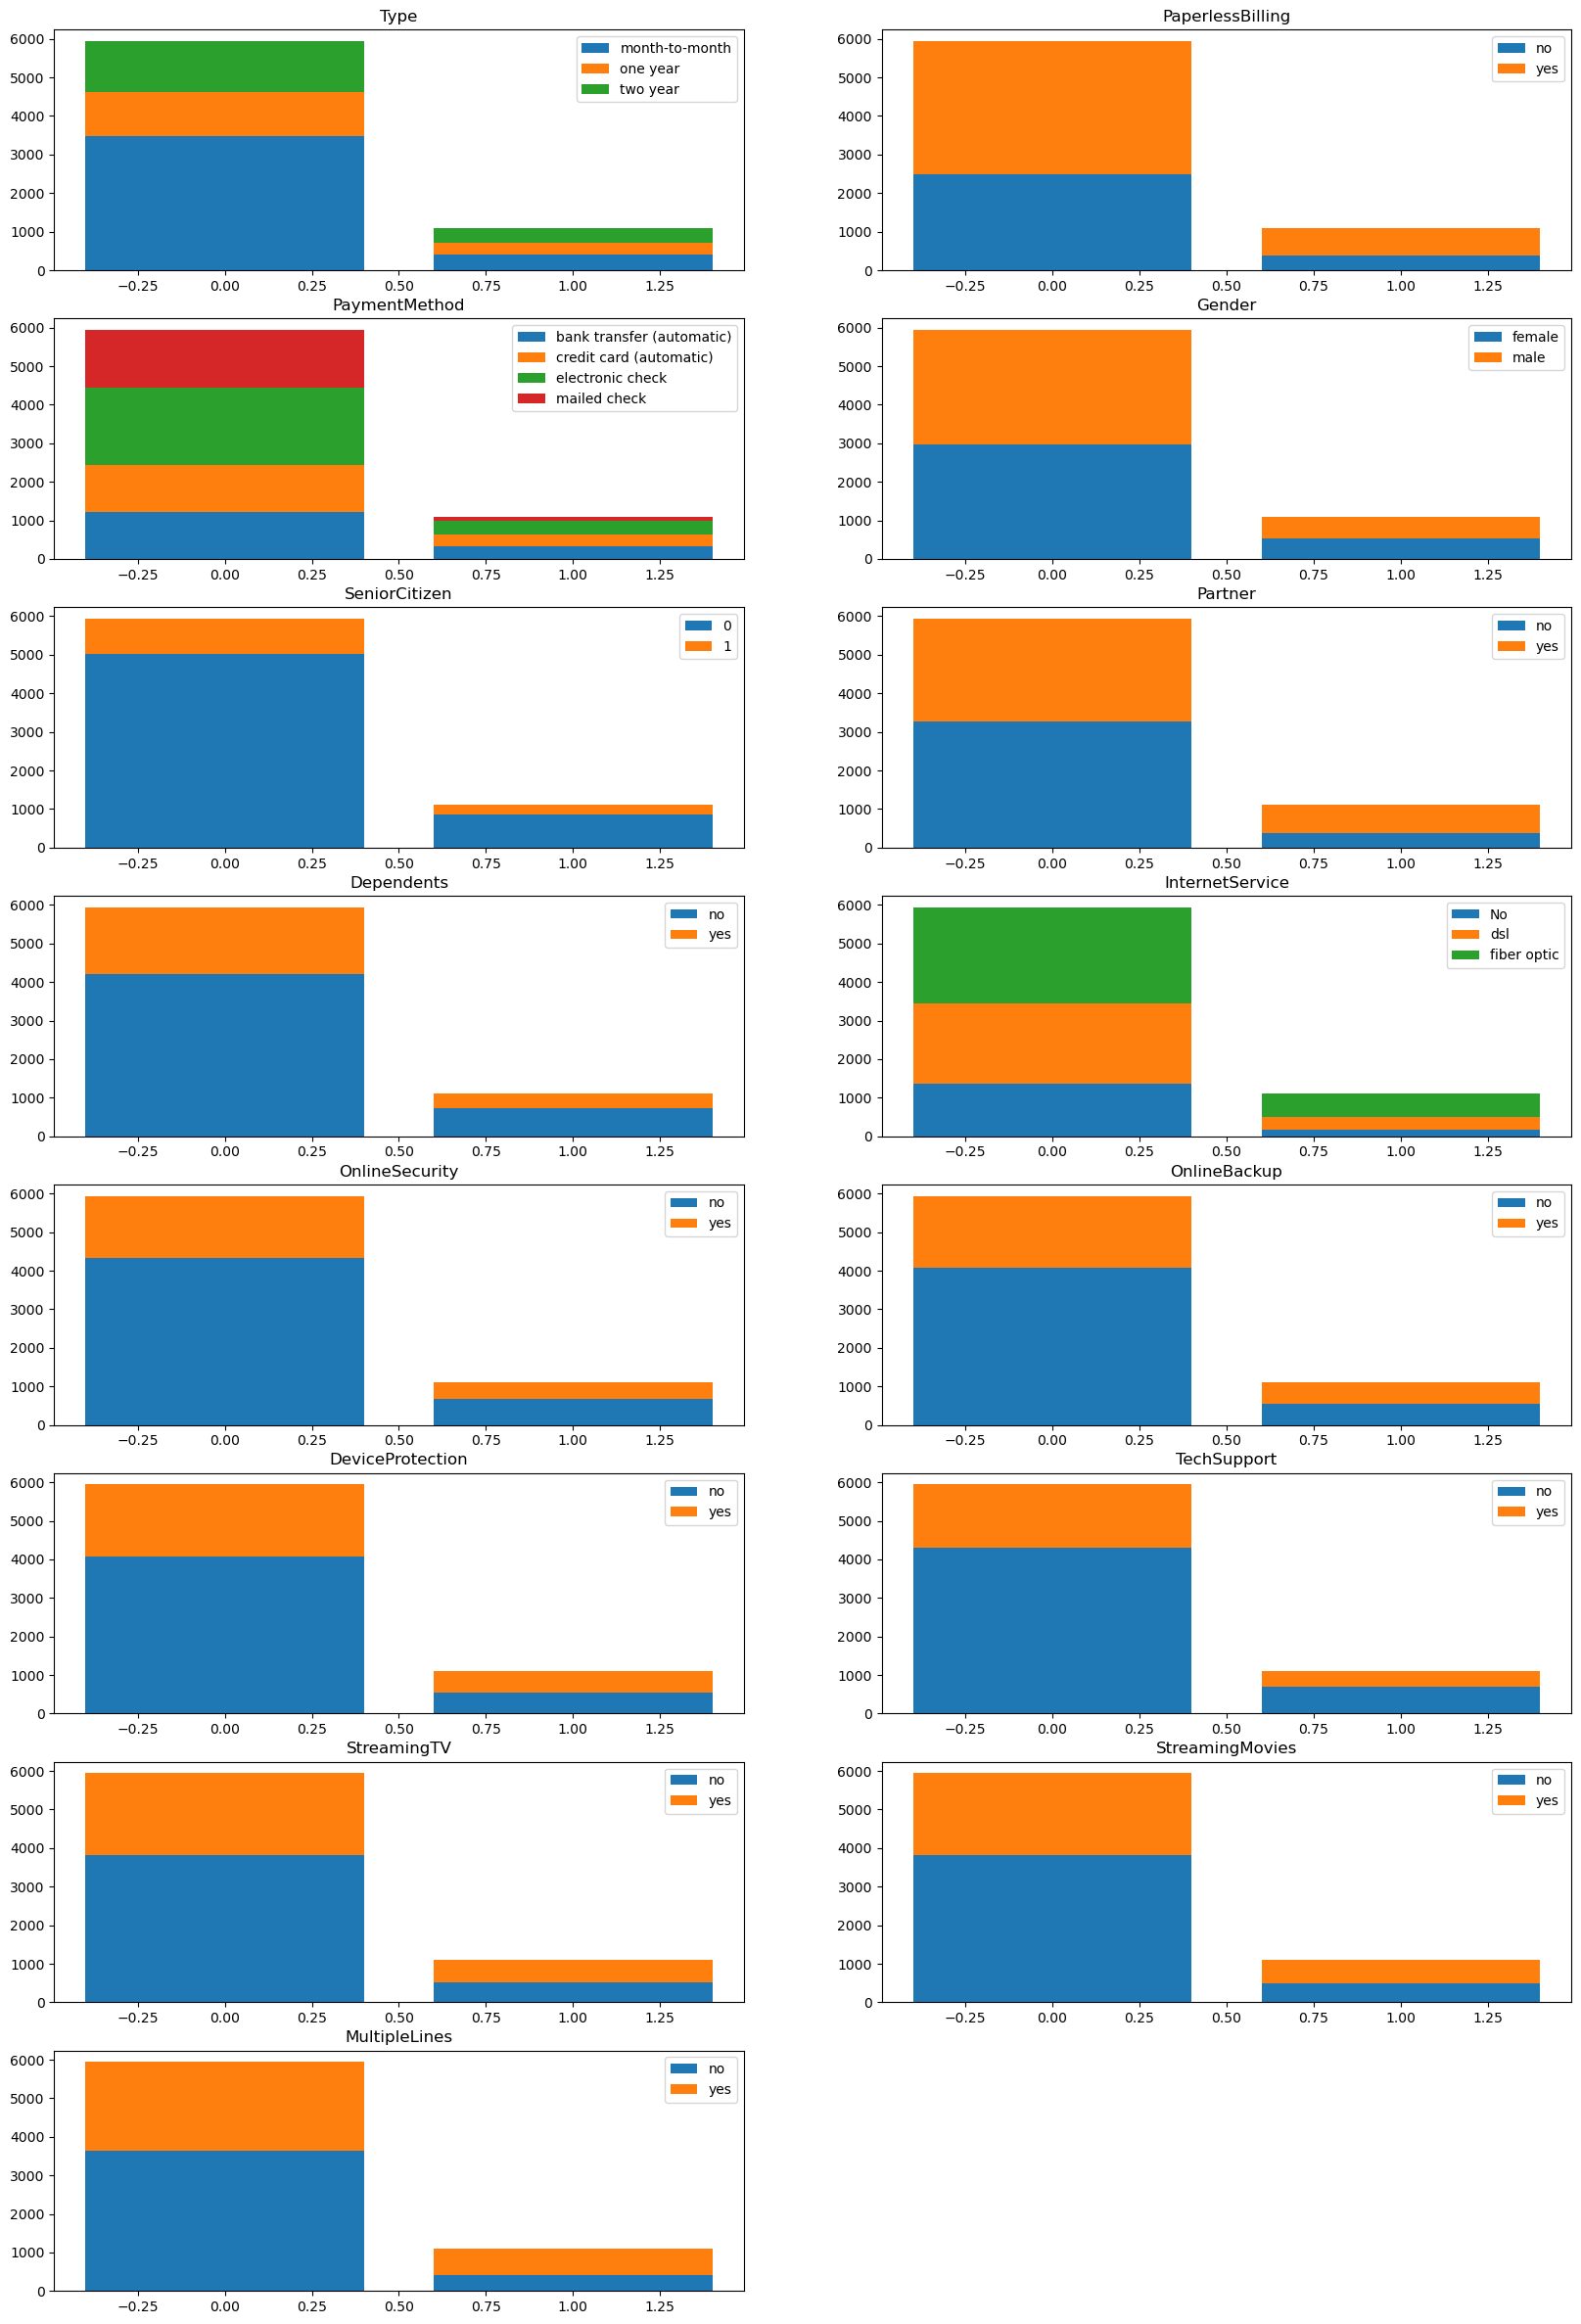

In [223]:
cols = 2
rows = int(np.ceil(len(categorial_columns) / cols))

plt.figure(figsize=(20, 30))

for idx, column in enumerate(categorial_columns):
    full_grouped_data = full_data.groupby([column, 'Churn'])['Churn'].count()
    full_grouped_data = full_grouped_data.unstack()
    
    ax = plt.subplot(rows, cols, idx + 1)

    ax.bar(full_grouped_data.T.index, full_grouped_data.T[full_grouped_data.T.columns[0]], label=full_grouped_data.T.columns[0])
    bottom = np.array(full_grouped_data.T[full_grouped_data.T.columns[0]])
    for color_idx, value in enumerate(full_grouped_data.T.columns[1:]): 
        ax.bar(full_grouped_data.T.index, full_grouped_data.T[value], bottom=bottom, label=value)
        bottom += np.array(full_grouped_data.T[value])
    plt.title(column)
    plt.legend()
        
plt.show()

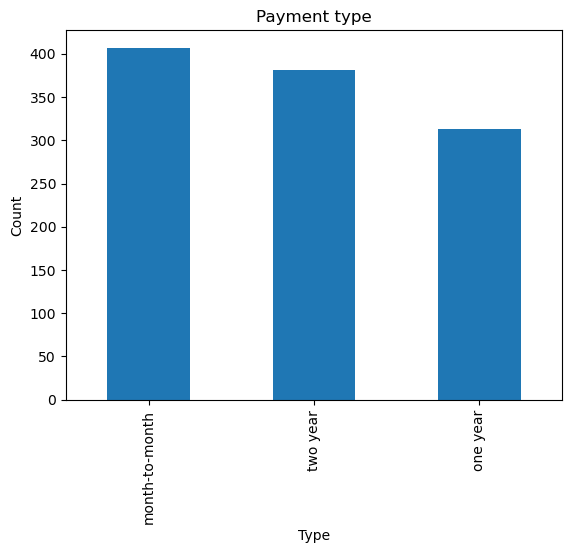

In [224]:
sorted_data = full_data[full_data['Churn'] == 1]

sorted_data['Type'].value_counts().plot(kind='bar')
plt.xlabel('Type')
plt.ylabel('Count')
plt.title('Payment type')
plt.show()

# Выводы:
* Доля отказов среди от типа оплаты примерно одинаковая для всех трех типов: больше всего помесячная, потом 2 года, меньше всего - 1 год

<div class="alert alert-block alert-danger">
❌ <b>Ревью 6</b>: Доля уходящих с помесячной оплатой - треть, а у оставшихся больше половины. У ушедших доли одинаковые. Не могу согласиться с выводами. Нужно перерисовать чертежи так, чтобы по оси x откладывались различные значения категорий, а над ними два столбика с ушедшими и оставшимися (можно нормировать столбцы, чтобы были отчетливо видны доли). После этого можно будет легко сделать правильные выводы.
</div>

<div class="alert alert-block alert-info">
<b>Комментарий разработчика:</b> 
Исправил вывод, добавил график отказов от типа оплаты.
</div>

* Дополнительные услуги слабо влияют на отказы
* Пользователи использующие "Electronic check" для оплаты чаще отказываются от услуг, возможно в оплате онлайн есть какие-то неудобства
* Пенсионеры уходят реже, скорее всего, потому что пенсионеров меньше, чем остальных клентов,- они не являются целевыми клиентами услуг связи

<div class="alert alert-block alert-danger">
❌ <b>Ревью 6</b>: Пенсионерам соответствует 1? Почему тогда они чаще уходят?
</div>

<div class="alert alert-block alert-info">
<b>Комментарий разработчика:</b> 
Исправил вывод.
</div>

* Если пользователь не пользуется интернетом, то вероятность отказа ниже. Скорее всего это связано с тем, что более возрастные люди не хотят разбираться в том, как сменить поставщика услуг

Посмотрим на распределение количественных признаков относительно целевого признака Result

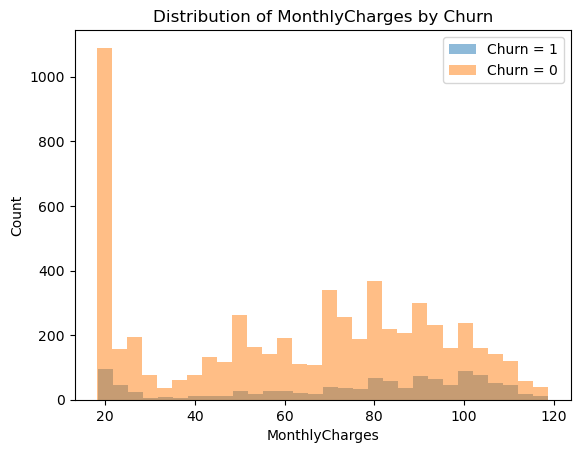

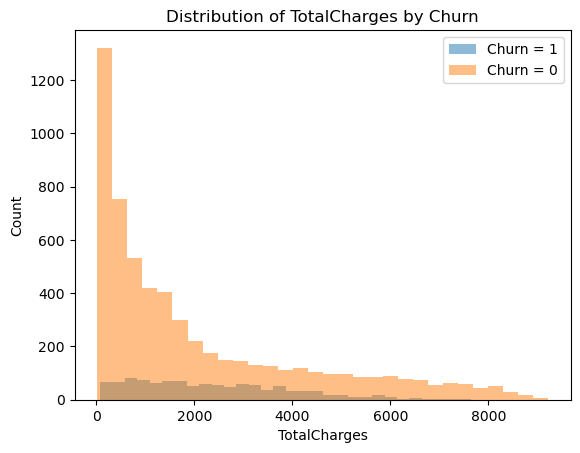

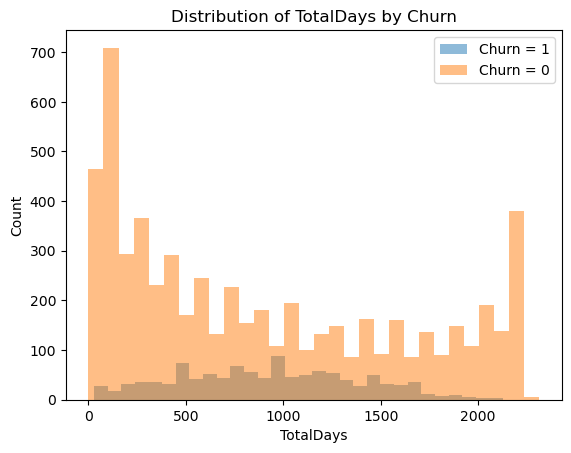

In [227]:
# поделить на 2 части где таргет 0 и 1
churn_1 = full_data[full_data['Churn'] == 1]
churn_0 = full_data[full_data['Churn'] == 0]

plt.hist(churn_1['MonthlyCharges'], bins=30, alpha=0.5, label='Churn = 1')
plt.hist(churn_0['MonthlyCharges'], bins=30, alpha=0.5, label='Churn = 0')
plt.xlabel('MonthlyCharges')
plt.ylabel('Count')
plt.title('Distribution of MonthlyCharges by Churn')
plt.legend()
plt.show()

plt.hist(churn_1['TotalCharges'], bins=30, alpha=0.5, label='Churn = 1')
plt.hist(churn_0['TotalCharges'], bins=30, alpha=0.5, label='Churn = 0')
plt.xlabel('TotalCharges')
plt.ylabel('Count')
plt.title('Distribution of TotalCharges by Churn')
plt.legend()
plt.show()

plt.hist(churn_1['TotalDays'], bins=30, alpha=0.5, label='Churn = 1')
plt.hist(churn_0['TotalDays'], bins=30, alpha=0.5, label='Churn = 0')
plt.xlabel('TotalDays')
plt.ylabel('Count')
plt.title('Distribution of TotalDays by Churn')
plt.legend()
plt.show()

<div class="alert alert-block alert-danger">
❌ <b>Ревью 6</b>: Чтобы было удобнее сравнивать распределения для ушедших и не ушедших, соответствующие диаграммы нужно нарисовать на одном чертеже и ли рядом с одинаковым масштабом осей.
</div>

<div class="alert alert-block alert-info">
<b>Комментарий разработчика:</b> 
Исправил графики, изобразил распределение ушедших/неушедших на одном графике
</div>

# Выводы:
* Со временем вероятность отказа от услуг снижается 
* Обычно отказывались от услуг те, кто платил больше

Рассмотррим матрицу корреляции

In [228]:
full_data.corr()['Churn'].sort_values(ascending=False)

Churn             1.000000
MonthlyCharges    0.154286
SeniorCitizen     0.056724
TotalCharges      0.051541
TotalDays         0.016578
Name: Churn, dtype: float64


* чем дольше клиент пользовался услугами, тем меньше вероятность, что он уйдет
* чем выше цена за услуги в месяц, тем больше вероятность, что клиент уйдет

In [229]:
full_data[numeric_columns].corr()

,MonthlyCharges,TotalCharges,TotalDays
MonthlyCharges,1.000000,0.629719,0.220054
TotalCharges,0.629719,1.000000,0.820329
TotalDays,0.220054,0.820329,1.000000


Можно заметить, что у нас присутствует проблема мультиколлинеарности в данных - корреляция между `TotalCharges` и `TotalDays` - 0.82, что логично - чем дольше клиент платит, тем больше итоговая сумма. Удалим поле `TotalCharges

In [230]:
del full_data['TotalCharges']
numeric_columns = ['MonthlyCharges', 'TotalDays']

In [231]:
full_data.head()

,CustomerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,Churn,TotalDays,InternetService,...,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Gender,SeniorCitizen,Partner,Dependents,MultipleLines
0,7590-vhveg,2020-01-01,2020-02-01,month-to-month,yes,electronic check,29.85,0,31,dsl,...,yes,no,no,no,no,female,0,yes,no,no
1,5575-gnvde,2017-04-01,2020-02-01,one year,no,mailed check,56.95,0,1036,dsl,...,no,yes,no,no,no,male,0,no,no,no
2,3668-qpybk,2019-10-01,2020-02-01,month-to-month,yes,mailed check,53.85,0,123,dsl,...,yes,no,no,no,no,male,0,no,no,no
3,7795-cfocw,2016-05-01,2020-02-01,one year,no,bank transfer (automatic),42.30,0,1371,dsl,...,no,yes,yes,no,no,male,0,no,no,no
4,9237-hqitu,2019-09-01,2020-02-01,month-to-month,yes,electronic check,70.70,0,153,fiber optic,...,no,no,no,no,no,female,0,no,no,no


# Подготовка данных для моделей

Удалим ненужные для обучения столбцы BeginDate и EndDate

In [232]:
del full_data['BeginDate'], full_data['EndDate'], full_data['CustomerID']

Закодируем категориальные признаки с помощью OrdinalEncoder.

<div class="alert alert-block alert-danger">
❌ <b>Ревью 6</b>: Порядковое кодирование подходит только для деревянных моделей. Для линейных моделей, включая логистическую регрессию, допустимо только OHE. Необходимо делать разное кодирование для разных моделей: для линейной - OHE, для деревянных OrdinalEncoder.
</div>

<div class="alert alert-block alert-info">
<b>Комментарий разработчика:</b> 
Сделал 2 типа features - для дерева OE, для лог. регрессии OHE
</div>

<div class="alert alert-block alert-warning">
⚠️ <b>Ревью 6</b>: Чтобы предотвратить утечку на кросс-валидации преобразование признаков лучше делать в конвейерах.
</div>



<div class="alert alert-block alert-danger">
❌ <b>Ревью 6</b>: Кодирование и масштабирование признаков должно выполняться после разделения на выборки.
</div>

<div class="alert alert-block alert-info">
<b>Комментарий разработчика:</b> 
Исправил, сделал масшабирование и кодирование после разделения на таргет и признаки
</div>

Выделим фичи и целевой показатель Churn

In [247]:
target = full_data['Churn'] 
features = full_data.drop(columns=['Churn'])

In [248]:
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.25,stratify=target, random_state=RANDOM_STATE)

<div class="alert alert-block alert-warning">
⚠️ <b>Ревью 6</b>: Для сохранения одинакового баланса классов в выборках лучше применять стратификацию.
</div>

<div class="alert alert-block alert-info">
<b>Комментарий разработчика:</b> 
Исправил, добавил стратификацию
</div>

Проведем масштабирование количественных признаков

In [249]:
scaler = StandardScaler()

scaler.fit(features_train[numeric_columns])

features_train = features_train.copy()
features_train[numeric_columns] = scaler.transform(features_train[numeric_columns])

features_test = features_test.copy()
features_test[numeric_columns] = scaler.transform(features_test[numeric_columns])

Кодирование категориальных признаков

In [277]:
features_train_OE = features_train.copy()
features_train_OHE = features_train.copy()

features_test_OE = features_test.copy()
features_test_OHE = features_test.copy()

# OE
encoder = OrdinalEncoder()
encoder.fit(features_train_OE[categorial_columns])
features_train_OE[categorial_columns] = pd.DataFrame(encoder.transform(features_train_OE[categorial_columns]),
                                                columns=features_train_OE[categorial_columns].columns)
features_test_OE[categorial_columns] = pd.DataFrame(encoder.transform(features_test_OE[categorial_columns]),
                                                columns=features_test_OE[categorial_columns].columns)

# OHE
features_train_OHE = pd.get_dummies(features_train_OHE, columns=categorial_columns)
features_test_OHE = pd.get_dummies(features_test_OHE, columns=categorial_columns)

In [278]:
features_train_OE.head()

,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalDays,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Gender,SeniorCitizen,Partner,Dependents,MultipleLines
4169,0.0,1.0,3.0,1.201679,-0.597179,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
5322,NaN,NaN,NaN,0.556787,-0.153724,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3001,0.0,1.0,2.0,-1.492872,-0.906430,2.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0
4812,0.0,1.0,2.0,0.035207,-0.776603,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0
4711,0.0,1.0,2.0,-1.512869,0.113223,2.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0


Получили после применения OrdinalEncoder, получили пропущенные значения в обучающей и тестовой выборке, такое может случится из-за некоректного заполнения пропусков, но мы заполнили всего 11 значений, скорее ошибка может быть в самих данных, исправляем, заполняя пропуски самым частым значением

In [279]:
features_train_OE = features_train_OE.fillna(features_train_OE.mode().iloc[0])
features_test_OE = features_test_OE.fillna(features_test_OE.mode().iloc[0])

Проверим распределение классов

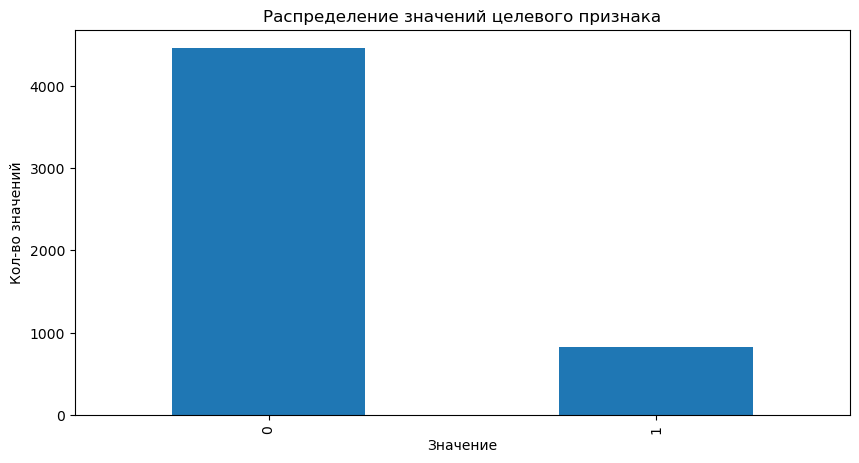

In [280]:
target_train.value_counts().plot(
    kind='bar', 
    figsize=(10, 5), 
    legend=False, 
    title='Распределение значений целевого признака', 
).set(xlabel='Значение', ylabel='Кол-во значений')
plt.show()

Видим, что количество значений 0, больше чем 1, в этом ничего плохого нет, ведь в изначальных данных количество людей неотказавшихся от услуг больше чем отказавшихся, ничего не меняем для объективной оценки модели

<div class="alert alert-block alert-danger">
❌ <b>Ревью 6</b>: Апсамплинг с кросс-валидацией без конвейеров - утечка данных и необъективная оценка модели, так как баланс классов в тестовой выборке, а так же в валидационных фолдах должен быть исходным. С кросс-валидацией нужно делать апсамлинг либо специальными библиотеками, либо отказаться от него и добиваться качества, подбирая гиперпараметры. Достаточно было бы использовать гиперпараметр class_weights='balanced' для балансировки с учетом наличия в проекте дополнительноой метрики accuracy, чувствительной к дисбалансу.
</div>

<div class="alert alert-block alert-info">
<b>Комментарий разработчика:</b> 
Убрал апсамплинг, потому что модель получилась необъективная
</div>

# Обучение моделей

In [256]:
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}

model = LogisticRegression(solver='lbfgs', n_jobs=-1)

search = GridSearchCV(model, param_grid, cv=5, scoring='roc_auc')
search.fit(features_train_OHE, target_train)

print("Best parameters:", search.best_params_)
print("Best score:", search.best_score_)

best_model = search.best_estimator_
predicted_probalities = best_model.predict_proba(features_test_OHE)[:, 1]

Best parameters: {'C': 10}
Best score: 0.7561645379940165


<div class="alert alert-block alert-danger">
❌ <b>Ревью 6</b>:
    
- Выбор лучший модели осуществляется сравнением метрик на кросс-валидации best_score_
- Подсчет метрики на тестовой выборке делается только для одной лучшей модели
    
</div>

<div class="alert alert-block alert-info">
<b>Комментарий разработчика:</b> 
Исправил
</div>

In [257]:
def plot_roc_curve(target_test, predictions):
    print('ROC-AUC score', roc_auc_score(target_test, predictions))
    
    fpr, tpr, thresholds = roc_curve(target_test, predictions)

    plt.figure(figsize=(11, 5))
    
    plt.plot(fpr, tpr)
    
    plt.plot([0, 1], [0, 1], linestyle='--')
    
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    
    plt.title('ROC-кривая')
    
    plt.show()

ROC-AUC score 0.7542909580325462


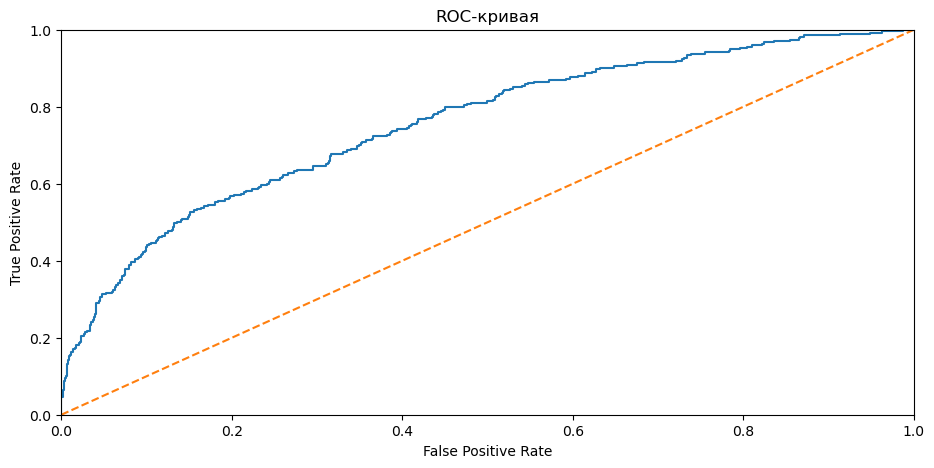

In [258]:
plot_roc_curve(target_test, predicted_probalities)

<div class="alert alert-block alert-danger">
❌ <b>Ревью 6</b>: Кривую достаточно нарисовать только для одной лучшей модели при тестировании.
</div>

<div class="alert alert-block alert-info">
<b>Комментарий разработчика:</b> 
Иправил, построил только для лучшей модели из прошлого пункта
</div>

In [281]:
param_grid = {
    'max_depth': [5, 10, 20, 25],
    'min_samples_split': [2, 3, 4, 10],
    'min_samples_leaf': [2, 3, 4, 10],
    'n_estimators': [10, 50, 100, 130, 150], 
}

model = RandomForestClassifier(random_state=RANDOM_STATE)

search = GridSearchCV(model, param_grid, cv=5, scoring='roc_auc')
search.fit(features_train_OE, target_train)

print("Best parameters:", search.best_params_)
print("Best score:", search.best_score_)

best_model = search.best_estimator_
predicted_probalities = best_model.predict_proba(features_test_OE)[:, 1]


Best parameters: {'max_depth': 10, 'min_samples_leaf': 3, 'min_samples_split': 10, 'n_estimators': 130}
Best score: 0.7566621603375576


<div class="alert alert-block alert-warning">
⚠️ <b>Ревью 6</b>: Гиперпараметры подобраны на границе сетки. Велика вероятность, что они не лучшие.
</div>

<div class="alert alert-block alert-info">
<b>Комментарий разработчика:</b> 
Добавляю еще гиперпараметры, чтобы убедиться, что подобранные не будут граничными
</div>

ROC-AUC score 0.7875247767037807


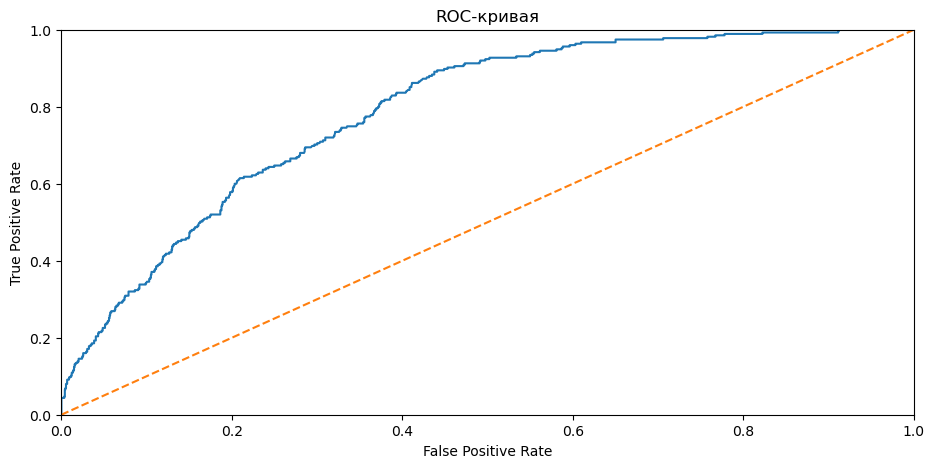

In [282]:
plot_roc_curve(target_test, predicted_probalities)

In [284]:
param_grid = {
    'learning_rate': [0.1, 0.3, 0.5],
    'iterations': [50, 100, 15],
    'l2_leaf_reg': [3, 4, 9]
}

model = CatBoostClassifier(random_state=RANDOM_STATE, verbose=0)

search = GridSearchCV(model, param_grid, cv=5, scoring='roc_auc')
search.fit(features_train_OE, target_train)

print("Best parameters:", search.best_params_)
print("Best score:", search.best_score_)

predicted_probalities = search.best_estimator_.predict_proba(features_test_OE)[:, 1]

Best parameters: {'iterations': 100, 'l2_leaf_reg': 3, 'learning_rate': 0.5}
Best score: 0.850102691562159


<div class="alert alert-block alert-warning">
⚠️ <b>Ревью 6</b>: Гиперпараметры подобраны на границе сетки. Велика вероятность, что они не лучшие.
</div>

<div class="alert alert-block alert-info">
<b>Комментарий разработчика:</b> 
Добавляю еще гиперпараметры, чтобы убедиться, что подобранные не будут граничными
</div>

ROC-AUC score 0.896613238712835


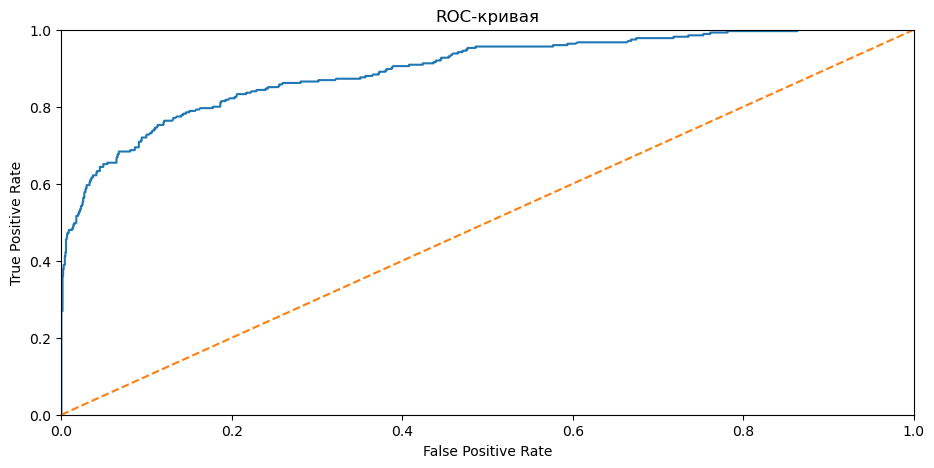

In [285]:
plot_roc_curve(target_test, predicted_probalities)

In [288]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.1, 0.3, 0.5],
    'base_estimator__max_depth': [3, 5, None],
    'base_estimator__min_samples_split': [2, 5, 10],
}

base_estimator = DecisionTreeClassifier(random_state=RANDOM_STATE)

model = AdaBoostClassifier(base_estimator=base_estimator, random_state=RANDOM_STATE)

search = GridSearchCV(model, param_grid, cv=5, scoring='roc_auc')
search.fit(features_train_OE, target_train)
print("Best parameters:", search.best_params_)
print("Best score:", search.best_score_)

Best parameters: {'base_estimator__max_depth': 3, 'base_estimator__min_samples_split': 10, 'learning_rate': 0.1, 'n_estimators': 100}
Best score: 0.8867205577091786


ROC-AUC score 0.896613238712835


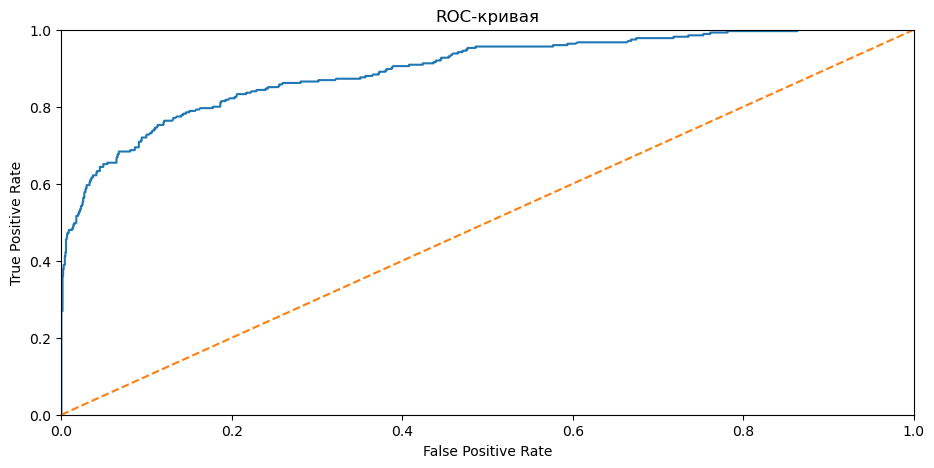

In [289]:
plot_roc_curve(target_test, predicted_probalities)

AdaBoostClassifier показал лучшее значение метрики ROC-AUC - 0.8867205577091786, выбираем его

<div class="alert alert-block alert-danger">
❌ <b>Ревью 6</b>: Модель нужно выбрать по метрикам на кросс-валидации, а не на тесте.
</div>

<div class="alert alert-block alert-info">
<b>Комментарий разработчика:</b> 
Исправил
</div>

Вычилим важность факторов

In [290]:
importances_df = pd.DataFrame(search.best_estimator_.feature_importances_, index = features_test.columns, columns=['importances'])
importances_df = importances_df.sort_values(by='importances', ascending=False)
importances_df

,importances
TotalDays,0.575494
MonthlyCharges,0.270571
MultipleLines,0.026322
PaymentMethod,0.025336
InternetService,0.022057
Type,0.013501
SeniorCitizen,0.010594
PaperlessBilling,0.010409
Dependents,0.010132
StreamingTV,0.007283


<div class="alert alert-block alert-danger">
❌ <b>Ревью 6</b>: Декларируется выбор CatBoost, а важность признаков считается по последней в блокноте модели. Нужно проанализировать важность признаков для выбранной лучшей модели. Важность у TotalDays не должна быть пустой. Что-то не то в сопоставлении имен признаков и значений важности.
</div>

<div class="alert alert-block alert-info">
<b>Комментарий разработчика:</b> 
Выбрал AdaBoostClassifier, его AUC-ROC наибольший, поэтому считаю по последней модели - AdaBoostClassifier
</div>

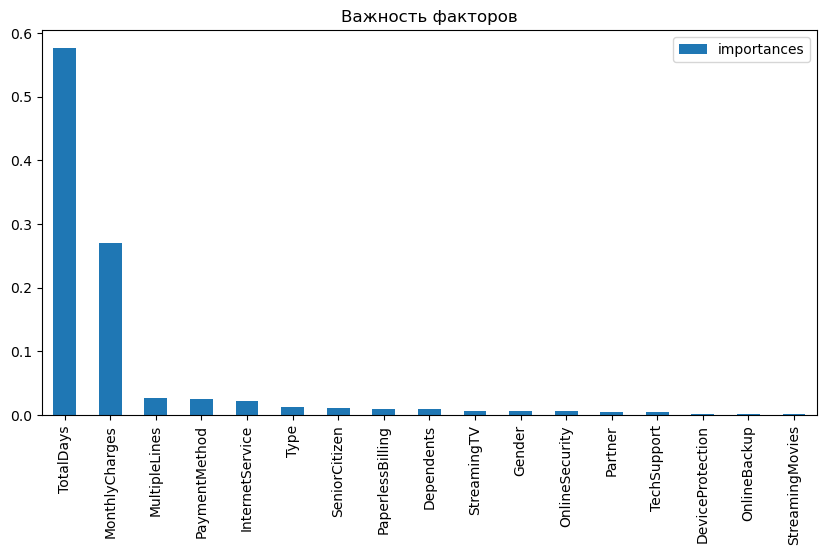

In [291]:
importances_df.plot(kind='bar', figsize=(10, 5), title='Важность факторов')
plt.show()

<div class="alert alert-block alert-danger">
❌ <b>Ревью 6</b>: По требованию заказчика для лучшей модели нужно посчитать дополнительную метрику accuracy на тестовой выборке, построить матрицу ошибок и сделать выводы об итоговом качестве модели.
</div>

<div class="alert alert-block alert-info">
<b>Комментарий разработчика:</b> 
Добавил ниже
</div>

In [293]:
# предсказания модели на тестовой выборке
predictions = search.best_estimator_.predict(features_test_OE)

# вычисление метрики accuracy
accuracy = accuracy_score(target_test, predictions)
print("Accuracy:", accuracy)

# построение матрицы ошибок
confusion_mat = confusion_matrix(target_test, predictions)
print("Confusion Matrix:")
print(confusion_mat)

Accuracy: 0.938671209540034
Confusion Matrix:
[[1482    4]
 [ 104  171]]


Верно классифицированные образцы (True Negatives): 1482. Это количество образцов, отнесенных моделью к отрицательному классу (0), которые действительно принадлежат к отрицательному классу.

Ложно положительные образцы (False Positives): 4. Это количество образцов, отнесенных моделью к положительному классу (1), которые на самом деле принадлежат к отрицательному классу.

Ложно отрицательные образцы (False Negatives): 104. Это количество образцов, отнесенных моделью к отрицательному классу (0), которые на самом деле принадлежат к положительному классу.

Верно классифицированные положительные образцы (True Positives): 171. Это количество образцов, отнесенных моделью к положительному классу (1), которые действительно принадлежат к положительному классу.

Модель достигает достаточно высокой точности с результатом 0.9387, что означает, что около 93.87% образцов правильно классифицированы. Это говорит о том, что модель имеет хорошую способность обобщения и может давать достаточно точные прогнозы.